In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import glob
import math
import csv
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from numpy.linalg import eig, inv
from scipy.spatial import ConvexHull
%matplotlib inline


In [2]:
def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

def ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])


def ellipse_angle_of_rotation( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return 0.5*np.arctan(2*b/(a-c))


def ellipse_axis_length( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])

def ellipse_angle_of_rotation2( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    if b == 0:
        if a > c:
            return 0
        else:
            return np.pi/2
    else:
        if a > c:
            return np.arctan(2*b/(a-c))/2
        else:
            return np.pi/2 + np.arctan(2*b/(a-c))/2

In [3]:
#Variables definitions
#total Water molecules
N = 3375
#height
h = 50.0
#Simulation Box
L = 277.2
#Slab thickness
S = 1
#water density box
rho = np.zeros((int(h/S), int(L/S), int(L/S)))

In [4]:
#Loop to read configurations
for fileConfig in sorted(glob.glob("./hfobic/*gz")):
        





SyntaxError: unexpected EOF while parsing (<ipython-input-4-597895af0ee0>, line 6)

In [5]:
#for i in sorted(glob.glob("./hfobic/" + "*.pos"), key = lambda strFile: float(strFile[strFile.index("c/")+2:strFile.index(".pos")])):
a = np.genfromtxt("./hfobic/0.pos",dtype="float",skip_header=9)
#gets the Oxigen positions
Oatoms = a[np.where(a[:,1]==2)][:,2:] 

In [6]:
#Fix the boarder problem and calculate the CM
CM = np.sum(Oatoms, axis=0)/N

Oatoms[:,1:] -= CM[1:]

Oatoms_out_index  = np.where(abs(Oatoms[:,1]) > L/2)
Oatoms_out_index2 = np.where(Oatoms[Oatoms_out_index] > 0)
Oatoms[Oatoms_out_index2] -= L 
Oatoms_out_index3 = np.where(Oatoms[Oatoms_out_index] < 0)
Oatoms[Oatoms_out_index3] += L 

Oatoms_out_index  = np.where(abs(Oatoms[:,2]) > L/2)
Oatoms_out_index2 = np.where(Oatoms[Oatoms_out_index] > 0)
Oatoms[Oatoms_out_index2] -= L 
Oatoms_out_index3 = np.where(Oatoms[Oatoms_out_index] < 0)
Oatoms[Oatoms_out_index3] += L 

Oatoms[:,1:] += CM[1:]
CM = np.sum(Oatoms, axis = 0)/N



In [7]:
#Remove water molecules out from bridge
rC = 45.0
mask = np.sqrt(np.sum(Oatoms[:, 1:]**2, axis=1)) > rC
Oatoms = Oatoms[~mask]


In [8]:
#get atoms position from histogram
hist_count, bins_edges = np.histogramdd(Oatoms, bins =(int(h/S), int(L/S), int(L/S)), range = ((-h/2,h/2), (-L/2,L/2), (-L/2,L/2)))
bins_posY = (bins_edges[1][1:] - bins_edges[1][:-1])/2 + bins_edges[1][:-1]
bins_posZ = (bins_edges[2][1:] - bins_edges[2][:-1])/2 + bins_edges[2][:-1]
grid = []
for y in bins_posY:
    temp = []
    for z in bins_posZ:
        temp.append([y,z])
    grid.append(temp)
grid = np.array(grid)        
        

In [9]:
#Loop: 1) Colappse the O atoms inside 5A slabes into a plane, which is a cross section of the bridge

fitEllipseProfile = []
pointsProfile = []
hullData = []
nSlabs = 5
for i in range(0,len(hist_count), nSlabs):
    points_cross_section = np.sum(hist_count[i:i+nSlabs], axis=0)
    mask = points_cross_section > 0    
    px, py =  np.split(grid[mask], 2, axis = 1)
    px = px.flatten()
    py = py.flatten()
    pointsCH = np.stack((px,py), axis=-1)
    pointsProfile.append(pointsCH)
    #find the board
    hull = ConvexHull(pointsCH, qhull_options='Qi')
    hullData.append(hull)
    #fitting the ellipse
    fitting = fitEllipse(pointsCH[hull.vertices][:,0], pointsCH[hull.vertices][:,1])
    fitEllipseProfile.append(fitting)


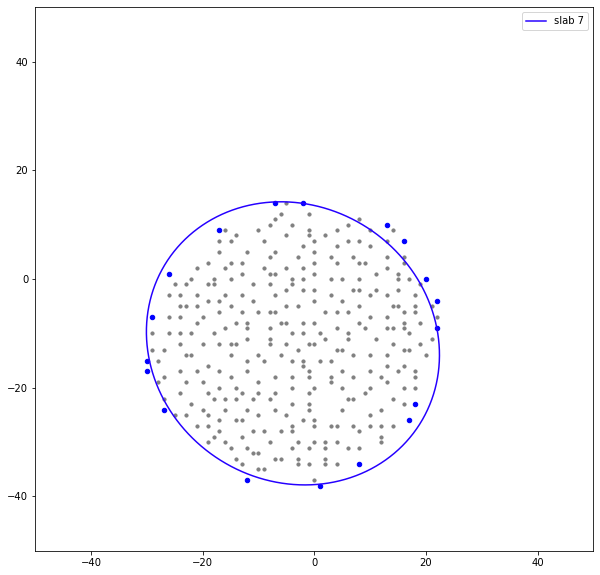

In [18]:
cmap = matplotlib.cm.get_cmap('hsv')
plt.figure(figsize=(10,10))
plt.ylim(-50,50)
plt.xlim(-50,50)

#for i in range(len(fitEllipseProfile) ):
for i in [7]:
    arc = 2
    R = np.arange(0,arc*np.pi, 0.01)
    center = ellipse_center(fitEllipseProfile[i])
    phi = ellipse_angle_of_rotation2(fitEllipseProfile[i])
    axes = ellipse_axis_length(fitEllipseProfile[i])

    a, b = axes
    xx = center[0] + a*np.cos(R)*np.cos(phi) - b*np.sin(R)*np.sin(phi)
    yy = center[1] + a*np.cos(R)*np.sin(phi) + b*np.sin(R)*np.cos(phi)
    
    plt.scatter(pointsProfile[i][:, 0], pointsProfile[i][:, 1],  color='grey', s=10, marker='o')
    plt.scatter(pointsProfile[i][hullData[i].vertices, 0], pointsProfile[i][hullData[i].vertices, 1],  color='b', s=20, marker='o')
    
    #plt.plot(pointsCH[hull.vertices[0],0], pointsCH[hull.vertices[0],1], 'ro')
    plt.plot(xx,yy, color = cmap(i/10), label = 'slab %d' % (i))
plt.legend()    
plt.savefig('./find_ellipse_All_profile2.png')
